<a id="top"></a>
# NDVI/EVI Phenology

<hr><hr>

# Notebook Summary

This notebook calculates vegetation phenology changes using Landsat 7 and/or Landsat 8 data. To detect changes in plant life, the algorithm uses either the Normalized Difference Vegetation Index (NDVI) or the Enhanced Vegetation Index (EVI), which are common proxies for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  
<br>
There are two output products. The first output product is a time series boxplot of NDVI or EVI with the data potentially binned by week, month, week of year, or month of year. The second output product is a time series lineplot of the mean NDVI or EVI for each year, with the data potentially binned by week or month. This product is useful for comparing years to each other.
<br><br>
See this website for more information: https://phenology.cr.usgs.gov/ndvi_foundation.php

<hr><hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube, Remove Clouds, and Calculate the Vegetation Index](#load_data)
* [Create Phenology Products](#phenology_products)
    * [Plot the Vegetation Index Over Time in a Box-and-Whisker Plot](#phenology_plot_1)
    * [Plot the Vegetation Index Over Time for Each Year](#phenology_plot_2)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [72]:
# Enable importing of utilities.
import sys
sys.path.append('..')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np  
import xarray as xr  
import pandas as pd
import datetime as dt

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

import datetime

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [10]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
8,LANDSAT_7,ls7_collections_sr_scene
67,LANDSAT_7,ls7_collections_sr_scene_lean
78,LANDSAT_7,ls7_collections_sr_scene_mini
19,LANDSAT_7,ls7_ledaps_amazon_river
20,LANDSAT_7,ls7_ledaps_bangladesh
35,LANDSAT_7,ls7_ledaps_bangladesh_bari
87,LANDSAT_7,ls7_ledaps_caqueta
21,LANDSAT_7,ls7_ledaps_colombia
22,LANDSAT_7,ls7_ledaps_ghana


In [11]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
9,LANDSAT_8,ls8_collections_sr_scene
69,LANDSAT_8,ls8_collections_sr_scene_lean
86,LANDSAT_8,ls8_lasrc_caqueta
73,LANDSAT_8,ls8_lasrc_honduras
32,LANDSAT_8,ls8_lasrc_lake_chad_full
33,LANDSAT_8,ls8_lasrc_meta_river
70,LANDSAT_8,ls8_lasrc_samoa
83,LANDSAT_8,ls8_lasrc_swiss_mini
77,LANDSAT_8,ls8_lasrc_switzerland


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [157]:
# Select Products and Platforms
# Examples: ghana, kenya, tanzania, sierra_leone, senegal
# It is possible to select ONE or BOTH of the datasets (L7 and L8)
# True = SELECT
# False = DO NOT SELECT

use_Landsat7 = False
use_Landsat8 = True
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_vietnam')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_vietnam')

# Select which spectral index to use to track changes in vegetation.
# Can be any of ['NDVI', 'EVI'].
spectral_index = 'NDVI'

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [158]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_8 and product ls8_lasrc_vietnam:
Time Extents: ['2014-01-14' '2016-12-21']

Overlapping Extents:
Latitude Extents: (10.513792253812069, 12.611268610703856)
Longitude Extents: (106.78992434561737, 108.919201063567)
Time Extents: ['2014-01-14', '2016-12-21']


**Visualize the available data**

In [159]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [160]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Tanzania Grassland / Cropland
# latitude = (-4.5074, -4.4860) # North of Swaga Game Reserve
# longitude = (35.1349, 35.1735) # North of Swaga Game Reserve

# Tanzania Grassland / Cropland
# latitude = (-8.1541, -8.1272) # Southern Cropland 
# longitude = (33.2016, 33.2545) # Southern Cropland

# Aviv Coffee Farm, Tanzania (small)
# latitude = (-10.6999, -10.6959) 
# longitude = (35.2608, 35.2662) 

# Aviv Coffee Farm, Tanzania (surrounding)
# latitude = (-10.855, -10.560)
# longitude = (35.130, 35.400)

# Soybean Fields in Western Kenya (from Kizito)
# latitude = (-0.801180, -0.483689) # entire region
# longitude = (34.193792, 34.546329) # entire region

# Vietnam
latitude = (10.9358, 11.0358)
longitude = (107.1899, 107.2899)

# Time Period
start_date, end_date = datetime.datetime(2013,1,1), datetime.datetime(2015,12,31)
time_extents = (start_date, end_date)

**Visualize the selected area**

In [161]:
display_map(latitude, longitude)

## <span id="load_data">Load Data from the Data Cube, Remove Clouds, and Calculate the Vegetation Index[&#9652;](#top)</span>

In [162]:
from utils.data_cube_utilities.dc_load import load_multiplatform

measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
dataset, clean_mask, _ = \
    load_multiplatform(dc, platforms, products,
                       load_params=dict(lat=latitude, lon=longitude, time=time_extents,
                                        measurements=measurements))
cleaned_dataset = dataset.where(clean_mask)
del dataset

In [164]:
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI, EVI
if spectral_index == 'NDVI':
    vegetation_arr = NDVI(cleaned_dataset)
if spectral_index == 'EVI':
    vegetation_arr = EVI(cleaned_dataset)
cleaned_dataset[spectral_index] = vegetation_arr

## <span id="phenology_products">Create Phenology Products[&#9652;](#top)</span>

If no plots appear in the figures below, there is no data available for the region selected.

## <span id="phenology_plot_1">Plot the Vegetation Index Over Time in a Box-and-Whisker Plot[&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [166]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Specify whether to plot a curve fit of the vegetation index along time. Input can be either TRUE or FALSE
plot_curve_fit = True
assert isinstance(plot_curve_fit, bool), "The variable 'plot_curve_fit' must be "\
                                         "either True or False."

# Specify the target aggregation type of the curve fit. Input can be either 'mean' or 'median'.
curve_fit_target = 'median'
assert curve_fit_target in ['mean', 'median'], "The variable 'curve_fit_target' must be either "\
                                               "'mean' or 'median'."

# The maximum number of data points that appear along time in each plot.
# If more than this number of data points need to be plotted, a grid of plots will be created.
max_times_per_plot = 40 

<p style="color:red";><b>CHANGE INPUTS BELOW

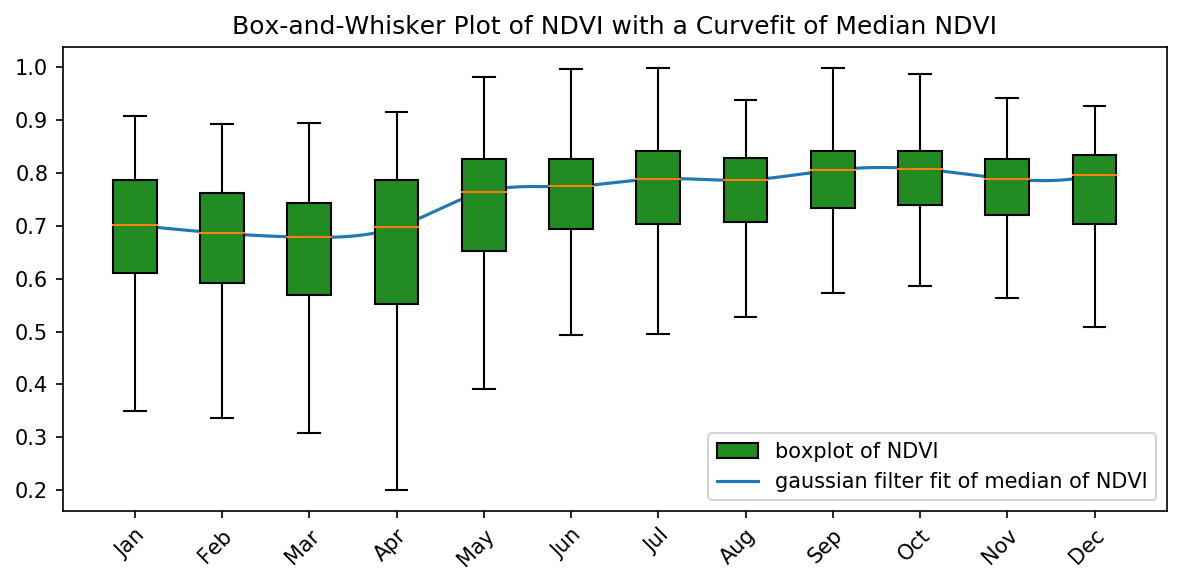

In [167]:
# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# None          = do not bin the data
# 'week'        = bin the data by week with an extended time axis
# 'month'       = bin the data by month with an extended time axis
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

# It is also possible to change some of the plotting features using the code below.

bin_by = 'monthofyear'
assert bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear'], \
    "The variable 'bin_by' can only have one of these values: "\
    "[None, 'week', 'month', 'weekofyear', 'monthofyear']"

aggregated_by_str = None
if bin_by is None:
    plotting_data = cleaned_dataset
elif bin_by == 'week':
    plotting_data = cleaned_dataset.resample(time='1w').mean()
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = cleaned_dataset.resample(time='1m').mean()
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
    aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={spectral_index:{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
if plot_curve_fit:
    params['plot_descs'][spectral_index][curve_fit_target] = [{'gaussian_filter':{}}]
    
xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150), 
                        max_times_per_plot=max_times_per_plot)
plt.title('Box-and-Whisker Plot of {0} with a Curvefit of Median {0}'.format(spectral_index))
plt.show()

## <span id="phenology_plot_2">Plot the Vegetation Index Over Time for Each Year[&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

Year 2013 has no data, so will not be plotted.


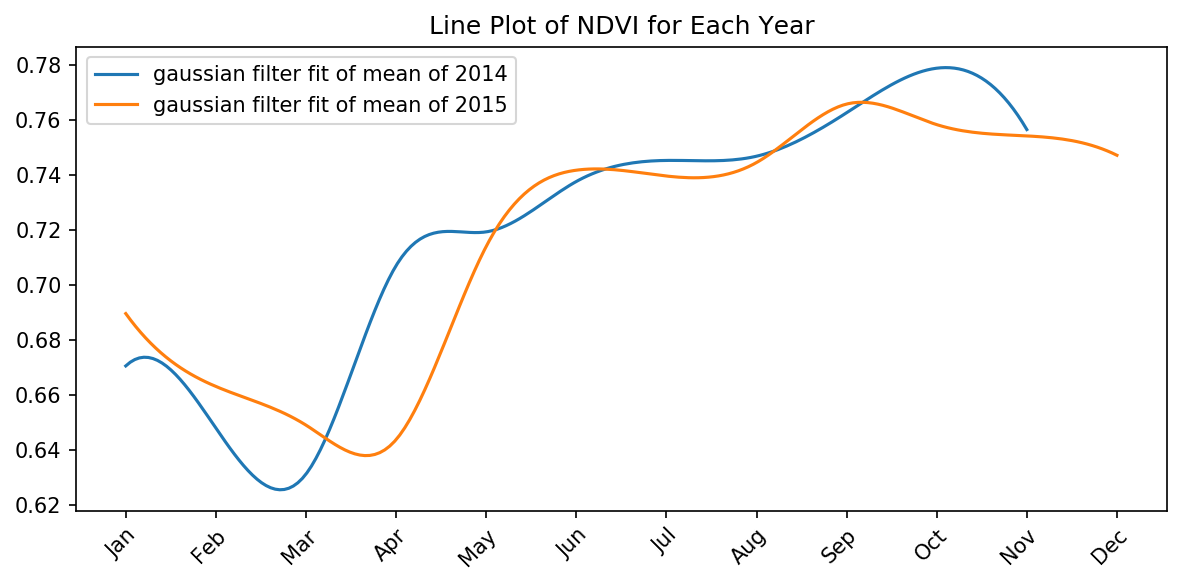

In [168]:
years_with_data = []
plot_descs = {}
plotting_data_years = {}
time_dim_name = None
for year in range(start_date.year, end_date.year+1):
    year_data = cleaned_dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))[spectral_index]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

    bin_by = 'monthofyear'
    
    assert bin_by in ['weekofyear', 'monthofyear'], \
        "The variable 'bin_by' can only have one of these values: "\
        "['weekofyear', 'monthofyear']"
    
    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'

    plotting_data_years[year] = plotting_data_year
    num_time_pts = len(plotting_data_year[time_dim_name])
    
    # Select the curve-fit type. 
    # See the documentation for `xarray_time_series_plot()` regarding the `plot_descs` parameter.
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

time_dim_name = 'week' if bin_by == 'weekofyear' else 'month' if bin_by == 'monthofyear' else 'time'

num_times = 54 if bin_by == 'weekofyear' else 12
time_coords_arr = np.arange(1, num_times+1) # In xarray, week and month indices start at 1.
time_coords_da = xr.DataArray(time_coords_arr, coords={time_dim_name:time_coords_arr}, 
                              dims=[time_dim_name], name=time_dim_name)
coords = dict(list(plotting_data_years.values())[0].coords)
coords[time_dim_name] = time_coords_da 
plotting_data = xr.Dataset(plotting_data_years, coords=coords)
params = dict(dataset=plotting_data, plot_descs=plot_descs)

xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Line Plot of {0} for Each Year'.format(spectral_index))
plt.show()